In [76]:
import timm
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import cv2

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [245]:
image_path = '/Users/seung/OneDrive/바탕 화면/딥플랜트/large-cat-breed-1553197454.jpg'  # Replace with your image path

image=Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize the image to match the model's input size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])
input_tensor = preprocess(image)

image=Image.open(image_path)


image_crop=image.resize((448,448))

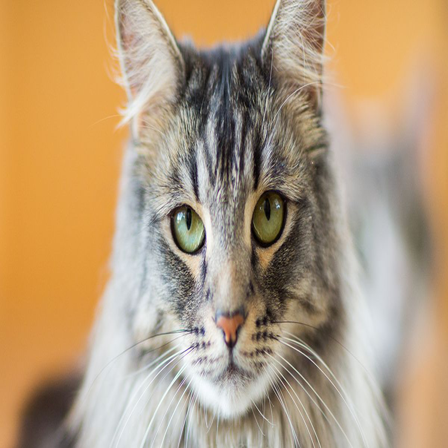

In [246]:
image_crop

In [163]:
model = timm.create_model('vit_base_patch32_clip_448.laion2b_ft_in12k_in1k',pretrained=True, exportable = True)
model = model.save(.pkl)
nodes, _ =get_graph_node_names(model)
nodes


['x',
 'patch_embed.getattr',
 'patch_embed.getitem',
 'patch_embed.getitem_1',
 'patch_embed.getitem_2',
 'patch_embed.getitem_3',
 'patch_embed.eq',
 'patch_embed._assert',
 'patch_embed.eq_1',
 'patch_embed._assert_1',
 'patch_embed.proj',
 'patch_embed.flatten',
 'patch_embed.transpose',
 'patch_embed.norm',
 'cls_token',
 'getattr',
 'getitem',
 'expand',
 'cat',
 'pos_embed',
 'add',
 'pos_drop',
 'patch_drop',
 'norm_pre',
 'blocks.0.norm1',
 'blocks.0.attn.getattr',
 'blocks.0.attn.getitem',
 'blocks.0.attn.getitem_1',
 'blocks.0.attn.getitem_2',
 'blocks.0.attn.qkv',
 'blocks.0.attn.reshape',
 'blocks.0.attn.permute',
 'blocks.0.attn.unbind',
 'blocks.0.attn.getitem_3',
 'blocks.0.attn.getitem_4',
 'blocks.0.attn.getitem_5',
 'blocks.0.attn.q_norm',
 'blocks.0.attn.k_norm',
 'blocks.0.attn.mul',
 'blocks.0.attn.transpose',
 'blocks.0.attn.matmul',
 'blocks.0.attn.softmax',
 'blocks.0.attn.attn_drop',
 'blocks.0.attn.matmul_1',
 'blocks.0.attn.transpose_1',
 'blocks.0.attn.resh

In [291]:
features={'blocks.5.attn.softmax':'out','blocks.6.attn.softmax':'out','blocks.7.attn.softmax':'out','blocks.8.attn.softmax':'out','blocks.9.attn.softmax':'out','blocks.10.attn.softmax':'out','blocks.11.attn.softmax':'out'}
feature_extractor = create_feature_extractor(model,return_nodes = features)
feature_extractor

VisionTransformer(
  (patch_embed): Module(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (blocks): Module(
    (0): Module(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Module(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Module(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout

In [247]:
input_tensor =input_tensor.unsqueeze(0)

In [248]:
input_tensor.shape

torch.Size([1, 3, 448, 448])

In [292]:
out = feature_extractor(input_tensor)

In [250]:
out['out'].shape

torch.Size([1, 12, 197, 197])

In [42]:
import matplotlib.pyplot as plt

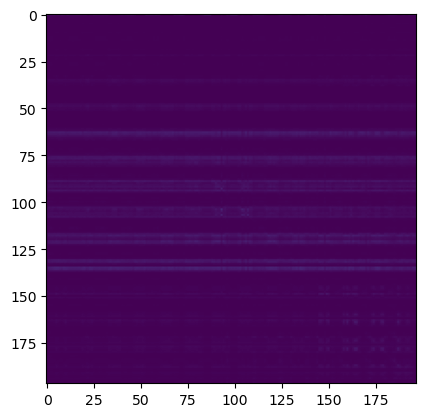

In [251]:
plt.imshow(out['out'][0].transpose(2,0).sum(-1).detach().numpy())

In [317]:
b=out['out']
b.shape


torch.Size([1, 12, 197, 197])

In [270]:
c=b.mean(axis = 1)

In [308]:
t=b[0]
t.mean(axis=0).shape

torch.Size([197, 197])

In [311]:
# using c
def rollout(attentions, discard_ratio, head_fusion):
    a=attentions[0]
    result = torch.eye(a.size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=0)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=0)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=0)[0]
            else:
                raise "Attention head fusion type Not supported"
            print(attention_heads_fused.shape)

            #Drop the lowest attentions, but don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)

    print(result)
    print(result.shape)
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 1:]
    print(mask.shape)
    
    # In case of 224x224 image, this brings us from 196 to 14
    width = 14
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    


In [345]:
mask = rollout(b,0.3,'max')

torch.Size([197, 197])
tensor([[0.9049, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0025],
        [0.2277, 0.2349, 0.0100,  ..., 0.0016, 0.0020, 0.0057],
        [0.2698, 0.0178, 0.2270,  ..., 0.0014, 0.0017, 0.0040],
        ...,
        [0.4266, 0.0024, 0.0014,  ..., 0.2230, 0.0043, 0.0037],
        [0.4477, 0.0032, 0.0013,  ..., 0.0136, 0.2236, 0.0094],
        [0.4417, 0.0089, 0.0037,  ..., 0.0141, 0.0587, 0.2109]])
torch.Size([197, 197])
torch.Size([196])


# using d

In [172]:
d=c[0][0].reshape(8,8)
d.shape

torch.Size([8, 8])

In [51]:
out['out'][0].mean(axis=0).shape

torch.Size([768])

In [173]:
c=out['out'][0].mean(axis=0)
mask=d.detach().numpy()

In [174]:
mask.shape

(8, 8)

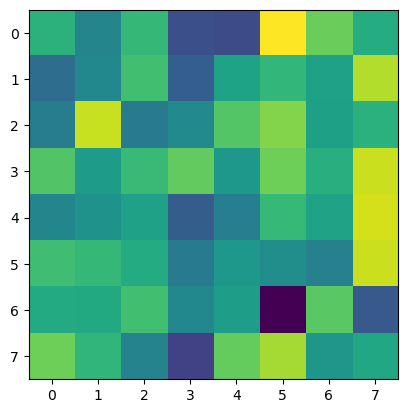

In [273]:
plt.imshow(d.detach().numpy())

In [342]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) /255

    print(heatmap.shape)
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)

    colormap_jet = plt.cm.get_cmap('jet')
    norm = plt.Normalize(vmin=0, vmax=1)
    color_bar = plt.cm.ScalarMappable(norm=norm, cmap=colormap_jet)
    color_bar.set_array([])

    # Plot the color bar
    plt.imshow(mask)
    plt.colorbar(color_bar)
    return np.uint8(255 * cam)

(448, 448, 3)


C:\Users\seung\AppData\Local\Temp\ipykernel_38100\3693432026.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_jet = plt.cm.get_cmap('jet')
C:\Users\seung\AppData\Local\Temp\ipykernel_38100\3693432026.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(color_bar)


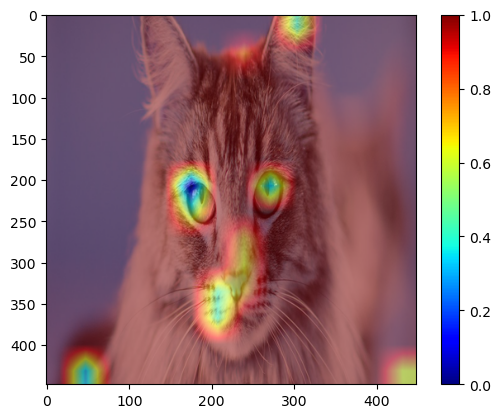

In [347]:
np_img = np.array(image_crop)[:, :, ::-1]
np_img.shape
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

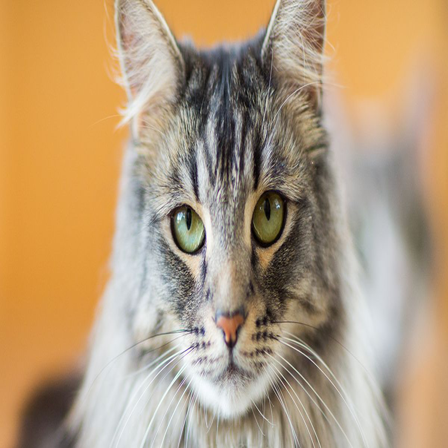

In [264]:
image_crop

(448, 448, 3)


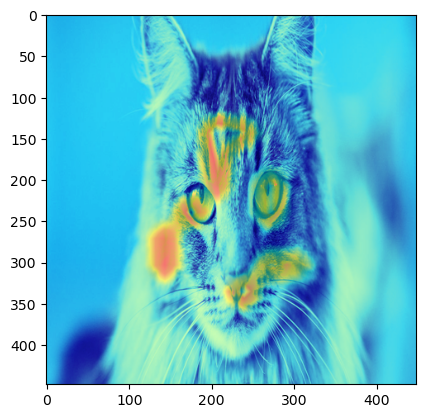

In [283]:
print(mask.shape)
plt.imshow(mask)